In [65]:
import pandas as pd
import numpy as np
import json
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


In [66]:
df = pd.read_csv("working_data.csv")

# Separate descriptors and target
player_descriptors = df.iloc[:, :3]
league = df['Lg']
cy_young_place = df['Cy_young']
X = df.iloc[:, 3:-1]

# Add league temporarily for sorting
X['Lg'] = league
y = cy_young_place

# Create separate datasets
x_al = X[X['Lg'] == 'AL'].drop(columns=['Lg'])
x_nl = X[X['Lg'] == 'NL'].drop(columns=['Lg'])


def transform_targets(y_sub):
    return np.where(y_sub == 1, 2,         
           np.where(y_sub > 1, 1, y_sub))  

y_al = transform_targets(y[league == 'AL'])
y_nl = transform_targets(y[league == 'NL'])



In [67]:
# Read selected features (from forest importance)
with open('forest_importance_nl.json', 'r') as f:
    selected_features_nl_importance = json.load(f)

with open('forest_importance_al.json', 'r') as f:
    selected_features_al_importance = json.load(f)

# Read selected features (from Chi-squared)
with open('chi2_selected_features_nl.json', 'r') as f:
    selected_features_nl_chi2 = json.load(f)


with open('chi2_selected_features_al.json', 'r') as f:
    selected_features_al_chi2 = json.load(f)

# Print selected features
print("Selected Features for NL imp:", selected_features_nl_importance)
print("Selected Features for AL imp:", selected_features_al_importance)
print("Selected Features for NL chi2:", selected_features_nl_chi2)
print("Selected Features for AL chi2:", selected_features_al_chi2)

Selected Features for NL imp: ['WAR', 'SO', 'ERA', 'W', 'FIP', 'IP', 'ERA+', 'WHIP', 'BF', 'W-L%']
Selected Features for AL imp: ['WAR', 'SO', 'FIP', 'ERA+', 'IP', 'ERA', 'BF', 'W', 'WHIP', 'GS']
Selected Features for NL chi2: ['WAR', 'W', 'ERA', 'CG', 'SHO', 'IP', 'SO', 'BF', 'ERA+', 'FIP']
Selected Features for AL chi2: ['WAR', 'W', 'CG', 'SHO', 'IP', 'SO', 'BK', 'BF', 'ERA+', 'FIP']


A consistent problem I ran into is that the model was being affected heavily by cumulative stats. However, with a tree and the year only half-way done, we can't do much. The NNC was able to get around this by scaling, but decision trees have no need to scale so I will make all the stats per inning pitched

In [68]:
#Used ChatGPT to help me construct a way to normalize the data
normalization_map = {
    'SO': ('SO', 'IP'),         # Strikeouts per inning
    'BB': ('BB', 'IP'),         # Walks per inning
    'H': ('H', 'IP'),           # Hits per inning
    'HR': ('HR', 'IP'),         # HRs per inning
    'W': ('W', 'G'),            # Wins per game
    'CG': ('CG', 'G'),          # Complete games per game
    'SHO': ('SHO', 'G'),        # Shutouts per game
    'BF': ('BF', 'IP'),         # Batters faced per inning
    'GS': ('GS', 'G'),          # Games started per game
    'WHIP': None,               # Already a rate
    'ERA': None,                # Already a rate
    'ERA+': None,               # Normalized
    'FIP': None,                # Already a rate
    'WAR': None,                 # Cumulative but fine (contextual)
    'IP': None
}

def normalize_selected_features(df, selected_features, normalization_map, season_innings):
    df = df.copy()
    new_df = pd.DataFrame(index=df.index)

    for feature in selected_features:
        rule = normalization_map.get(feature)
        if rule is None:
            if feature == 'IP':
                # Normalize IP by full season innings (e.g., 162 * 9 innings for a full season)
                new_df['IP_per_full_season'] = df['IP'] / season_innings
            else:
                new_df[feature] = df[feature]  # Keep as-is
        else:
            num, denom = rule
            with np.errstate(divide='ignore', invalid='ignore'):
                new_df[f"{num}_per_{denom}"] = df[num] / df[denom]

    return new_df.fillna(0)



In [69]:
#Dataset is a full season so 
season_innings = 162*9
# Normalize features for Random Forest Importance
x_nl_importance = normalize_selected_features(x_nl[selected_features_nl_importance + ['G']], selected_features_nl_importance, normalization_map, season_innings)
x_al_importance = normalize_selected_features(x_al[selected_features_al_importance +['G']], selected_features_al_importance, normalization_map, season_innings)

# Normalize features for Chi-squared Features
x_nl_chi2 = normalize_selected_features(x_nl[selected_features_nl_chi2 + ['G']], selected_features_nl_chi2, normalization_map, season_innings)
x_al_chi2 = normalize_selected_features(x_al[selected_features_al_chi2 + ['G']], selected_features_al_chi2, normalization_map, season_innings)




I will now perform a search for the best parameters that I found online at "https://www.geeksforgeeks.org/comparing-randomized-search-and-grid-search-for-hyperparameter-estimation-in-scikit-learn/"

In [70]:

param_grid = {
    'max_depth': [4, 5, 6, 7],
    'max_leaf_nodes': [10, 12, 15],
    'class_weight': [
        {0: 1, 1: 1, 2: 5},
        {0: 1, 1: 1, 2: 10},
        {0: 1, 1: 1, 2: 15},
        'balanced'
    ],
    'criterion': ['entropy', 'gini']
}

grid_search_al_imp = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search_al_imp.fit(x_al_importance, y_al)
al_imp_best_params = grid_search_al_imp.best_params_
print("Best parameters for AL Forest Importance: ", al_imp_best_params)

grid_search_nl_imp = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search_nl_imp.fit(x_nl_importance, y_nl)
nl_imp_best_params = grid_search_nl_imp.best_params_
print("Best parameters for NL Forest Importance: ", nl_imp_best_params )

grid_search_al_chi2 = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search_al_chi2.fit(x_al_chi2, y_al)
al_chi2_best_params = grid_search_al_chi2.best_params_
print("Best parameters for AL Chi2: ", al_chi2_best_params)

grid_search_nl_chi2 = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5)
grid_search_nl_chi2.fit(x_nl_chi2, y_nl)
nl_chi2_best_params = grid_search_nl_chi2.best_params_
print("Best parameters for NL Chi2: ", nl_chi2_best_params)


Best parameters for AL Forest Importance:  {'class_weight': {0: 1, 1: 1, 2: 5}, 'criterion': 'entropy', 'max_depth': 5, 'max_leaf_nodes': 12}
Best parameters for NL Forest Importance:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 10}
Best parameters for AL Chi2:  {'class_weight': {0: 1, 1: 1, 2: 10}, 'criterion': 'entropy', 'max_depth': 7, 'max_leaf_nodes': 15}
Best parameters for NL Chi2:  {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'max_leaf_nodes': 15}


In [71]:

#forest feature trees
clf_nl_forest = DecisionTreeClassifier(**nl_imp_best_params)
clf_nl_forest.fit(x_nl_importance, y_nl)
clf_al_forest = DecisionTreeClassifier(**al_imp_best_params)
clf_al_forest.fit(x_al_importance, y_al)

#chi2 feature trees
clf_nl_chi2 = DecisionTreeClassifier(**nl_chi2_best_params)
clf_nl_chi2.fit(x_nl_chi2, y_nl)
clf_al_chi2 = DecisionTreeClassifier(**al_chi2_best_params)
clf_al_chi2.fit(x_al_chi2, y_al)

DecisionTreeClassifier(class_weight={0: 1, 1: 1, 2: 10}, criterion='entropy',
                       max_depth=7, max_leaf_nodes=15)

Plot the Trees


forest tree nl:



[Text(0.359375, 0.9166666666666666, 'x[2] <= 2.445\nentropy = 1.585\nsamples = 353\nvalue = [117.667, 117.667, 117.667]'),
 Text(0.125, 0.75, 'x[2] <= 2.205\nentropy = 0.562\nsamples = 14\nvalue = [1.548, 13.371, 117.667]'),
 Text(0.2421875, 0.8333333333333333, 'True  '),
 Text(0.0625, 0.5833333333333334, 'entropy = 0.356\nsamples = 6\nvalue = [0.774, 10.697, 0.0]'),
 Text(0.1875, 0.5833333333333334, 'x[0] <= 5.2\nentropy = 0.209\nsamples = 8\nvalue = [0.774, 2.674, 117.667]'),
 Text(0.125, 0.4166666666666667, 'entropy = 0.548\nsamples = 2\nvalue = [0.387, 2.674, 0.0]'),
 Text(0.25, 0.4166666666666667, 'entropy = 0.032\nsamples = 6\nvalue = [0.387, 0.0, 117.667]'),
 Text(0.59375, 0.75, 'x[0] <= 2.95\nentropy = 0.998\nsamples = 339\nvalue = [116.118, 104.295, 0.0]'),
 Text(0.4765625, 0.8333333333333333, '  False'),
 Text(0.4375, 0.5833333333333334, 'x[9] <= 0.773\nentropy = 0.179\nsamples = 251\nvalue = [96.765, 2.674, 0.0]'),
 Text(0.375, 0.4166666666666667, 'entropy = 0.0\nsamples = 2

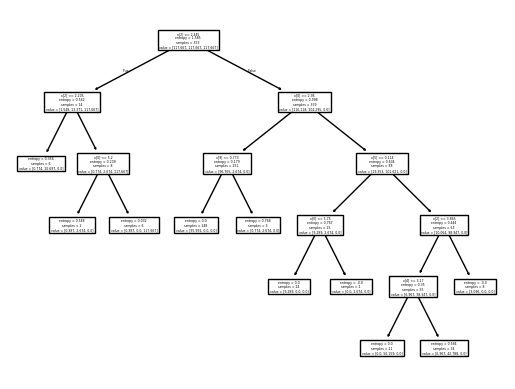

In [72]:
print("forest tree nl:\n")
plot_tree(clf_nl_forest)


forest tree al:



[Text(0.5277777777777778, 0.9166666666666666, 'x[0] <= 4.7\nentropy = 0.809\nsamples = 365\nvalue = [321.0, 39.0, 25.0]'),
 Text(0.2777777777777778, 0.75, 'x[2] <= 3.555\nentropy = 0.344\nsamples = 342\nvalue = [320, 22, 0]'),
 Text(0.4027777777777778, 0.8333333333333333, 'True  '),
 Text(0.1111111111111111, 0.5833333333333334, 'x[4] <= 0.105\nentropy = 0.936\nsamples = 54\nvalue = [35, 19, 0]'),
 Text(0.05555555555555555, 0.4166666666666667, 'entropy = 0.0\nsamples = 29\nvalue = [29, 0, 0]'),
 Text(0.16666666666666666, 0.4166666666666667, 'x[6] <= 4.064\nentropy = 0.795\nsamples = 25\nvalue = [6, 19, 0]'),
 Text(0.1111111111111111, 0.25, 'entropy = 0.0\nsamples = 10\nvalue = [0, 10, 0]'),
 Text(0.2222222222222222, 0.25, 'x[1] <= 0.952\nentropy = 0.971\nsamples = 15\nvalue = [6, 9, 0]'),
 Text(0.16666666666666666, 0.08333333333333333, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(0.2777777777777778, 0.08333333333333333, 'entropy = 0.811\nsamples = 12\nvalue = [3, 9, 0]'),
 Te

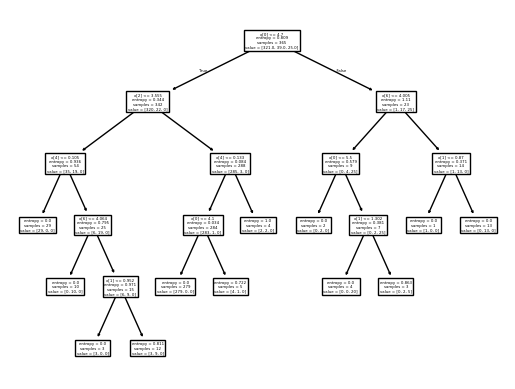

In [73]:
print("forest tree al:\n")
plot_tree(clf_al_forest)

chi2 tree nl:



[Text(0.43478260869565216, 0.9285714285714286, 'x[2] <= 2.445\nentropy = 1.585\nsamples = 353\nvalue = [117.667, 117.667, 117.667]'),
 Text(0.1956521739130435, 0.7857142857142857, 'x[2] <= 2.205\nentropy = 0.562\nsamples = 14\nvalue = [1.548, 13.371, 117.667]'),
 Text(0.31521739130434784, 0.8571428571428572, 'True  '),
 Text(0.08695652173913043, 0.6428571428571429, 'x[0] <= 4.4\nentropy = 0.356\nsamples = 6\nvalue = [0.774, 10.697, 0.0]'),
 Text(0.043478260869565216, 0.5, 'entropy = 0.0\nsamples = 1\nvalue = [0.387, 0.0, 0.0]'),
 Text(0.13043478260869565, 0.5, 'entropy = 0.218\nsamples = 5\nvalue = [0.387, 10.697, 0.0]'),
 Text(0.30434782608695654, 0.6428571428571429, 'x[0] <= 5.2\nentropy = 0.209\nsamples = 8\nvalue = [0.774, 2.674, 117.667]'),
 Text(0.21739130434782608, 0.5, 'x[1] <= 0.514\nentropy = 0.548\nsamples = 2\nvalue = [0.387, 2.674, 0.0]'),
 Text(0.17391304347826086, 0.35714285714285715, 'entropy = 0.0\nsamples = 1\nvalue = [0.0, 2.674, 0.0]'),
 Text(0.2608695652173913, 0.3

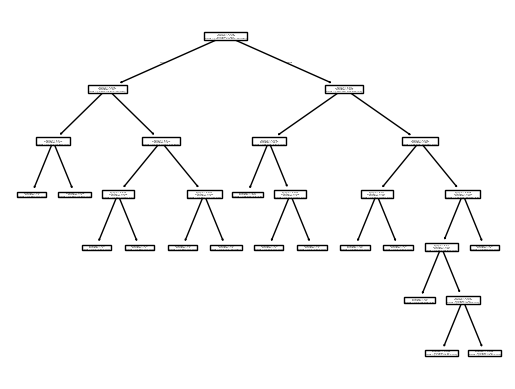

In [74]:
print("chi2 tree nl:\n")
plot_tree(clf_nl_chi2)

chi2 tree al:



[Text(0.5375, 0.9285714285714286, 'x[0] <= 4.7\nentropy = 0.969\nsamples = 365\nvalue = [321, 39, 50]'),
 Text(0.275, 0.7857142857142857, 'x[9] <= 3.555\nentropy = 0.344\nsamples = 342\nvalue = [320, 22, 0]'),
 Text(0.40625, 0.8571428571428572, 'True  '),
 Text(0.1, 0.6428571428571429, 'x[4] <= 0.105\nentropy = 0.936\nsamples = 54\nvalue = [35, 19, 0]'),
 Text(0.05, 0.5, 'entropy = 0.0\nsamples = 29\nvalue = [29, 0, 0]'),
 Text(0.15, 0.5, 'x[7] <= 4.064\nentropy = 0.795\nsamples = 25\nvalue = [6, 19, 0]'),
 Text(0.1, 0.35714285714285715, 'entropy = 0.0\nsamples = 10\nvalue = [0, 10, 0]'),
 Text(0.2, 0.35714285714285715, 'x[5] <= 0.952\nentropy = 0.971\nsamples = 15\nvalue = [6, 9, 0]'),
 Text(0.15, 0.21428571428571427, 'entropy = 0.0\nsamples = 3\nvalue = [3, 0, 0]'),
 Text(0.25, 0.21428571428571427, 'x[4] <= 0.116\nentropy = 0.811\nsamples = 12\nvalue = [3, 9, 0]'),
 Text(0.2, 0.07142857142857142, 'entropy = 0.811\nsamples = 4\nvalue = [3, 1, 0]'),
 Text(0.3, 0.07142857142857142, 'ent

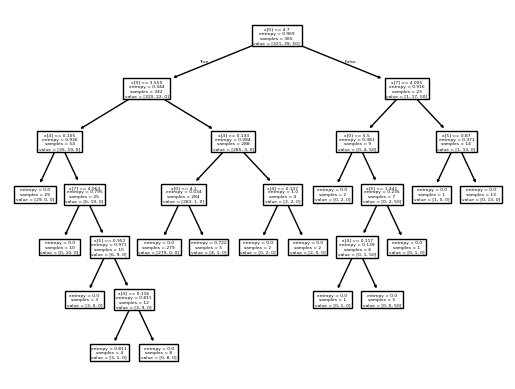

In [75]:
print("chi2 tree al:\n")
plot_tree(clf_al_chi2)

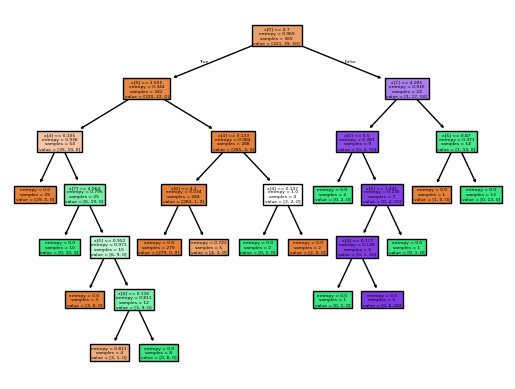

In [76]:

plot_tree(clf_al_chi2, filled=True)
plt.show()

In [77]:
#Model Evaluation 
k = 15
#Importance Trees
kf_nl_importance = KFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_importance = cross_val_score(clf_nl_forest, x_nl_importance, y_nl, cv=kf_nl_importance)
print(f"Accuracy for each fold: {scores_nl_importance}")
print(f"Average accuracy NL Importance: {np.mean(scores_nl_importance):.4f}")

kf_al_importance = KFold(n_splits=k, shuffle=True, random_state=42)
scores_al_importance = cross_val_score(clf_al_forest, x_al_importance, y_al, cv=kf_al_importance)
print(f"Accuracy for each fold: {scores_al_importance}")
print(f"Average accuracy AL importance: {np.mean(scores_al_importance):.4f}")


#Chi2 Trees 
kf_nl_chi2 = KFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_chi2 = cross_val_score(clf_nl_chi2, x_nl_chi2, y_nl, cv=kf_nl_chi2)
print(f"Accuracy for each fold: {scores_nl_chi2}")
print(f"Average accuracy NL chi2: {np.mean(scores_nl_chi2):.4f}")

kf_al_chi2 = KFold(n_splits=k, shuffle=True, random_state=42)
scores_al_chi2 = cross_val_score(clf_al_chi2, x_al_chi2, y_al, cv=kf_al_chi2)
print(f"Accuracy for each fold: {scores_al_chi2}")
print(f"Average accuracy AL chi2: {np.mean(scores_al_chi2):.4f}")


Accuracy for each fold: [0.875      0.875      0.875      0.875      1.         0.95833333
 0.95833333 0.91666667 0.95652174 0.91304348 0.91304348 0.86956522
 0.82608696 0.91304348 0.95652174]
Average accuracy NL Importance: 0.9121
Accuracy for each fold: [0.88       0.88       1.         0.96       0.96       0.95833333
 0.91666667 0.91666667 0.875      0.95833333 0.875      0.875
 0.875      0.91666667 0.91666667]
Average accuracy AL importance: 0.9176
Accuracy for each fold: [0.83333333 0.875      0.95833333 0.875      0.91666667 0.91666667
 0.95833333 0.91666667 0.91304348 0.91304348 0.86956522 0.86956522
 0.82608696 0.91304348 1.        ]
Average accuracy NL chi2: 0.9036
Accuracy for each fold: [0.88       0.84       1.         0.96       0.96       0.95833333
 0.91666667 0.91666667 0.91666667 1.         0.875      0.91666667
 0.875      0.91666667 0.91666667]
Average accuracy AL chi2: 0.9232


In my reasearch it showed that KFold is not the best way to calculate accuracy for decision trees. So I will try with StratifiedKFold

In [78]:
from sklearn.model_selection import StratifiedKFold
k = 5
#Importance Trees
skf_nl_importance = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_importance = cross_val_score(clf_nl_forest, x_nl_importance, y_nl, cv=skf_nl_importance)
print(f"Accuracy for each fold: {scores_nl_importance}")
print(f"Average accuracy NL Importance: {np.mean(scores_nl_importance):.4f}")

skf_al_importance = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_al_importance = cross_val_score(clf_al_forest, x_al_importance, y_al, cv=skf_al_importance)
print(f"Accuracy for each fold: {scores_al_importance}")
print(f"Average accuracy AL importance: {np.mean(scores_al_importance):.4f}")


#Chi2 Trees 
skf_nl_chi2 = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_nl_chi2 = cross_val_score(clf_nl_chi2, x_nl_chi2, y_nl, cv=skf_nl_chi2)
print(f"Accuracy for each fold: {scores_nl_chi2}")
print(f"Average accuracy NL chi2: {np.mean(scores_nl_chi2):.4f}")

skf_al_chi2 = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
scores_al_chi2 = cross_val_score(clf_al_chi2, x_al_chi2, y_al, cv=skf_al_chi2)
print(f"Accuracy for each fold: {scores_al_chi2}")
print(f"Average accuracy AL chi2: {np.mean(scores_al_chi2):.4f}")

Accuracy for each fold: [0.85915493 0.91549296 0.92957746 0.95714286 0.92857143]
Average accuracy NL Importance: 0.9180
Accuracy for each fold: [0.8630137  0.95890411 0.95890411 0.94520548 0.87671233]
Average accuracy AL importance: 0.9205
Accuracy for each fold: [0.87323944 0.87323944 0.91549296 0.94285714 0.92857143]
Average accuracy NL chi2: 0.9067
Accuracy for each fold: [0.91780822 0.95890411 0.94520548 0.97260274 0.89041096]
Average accuracy AL chi2: 0.9370


KFold and StratifiedKFold are great for predicting accuracy, however, in a dataset flooded with cy-young losers it will imbalance the data. I will use F1 score which weighs precision and recall to see how many times it correctly predicts the winner

In [79]:
#First we predict a class based on our model
y_nl_importance_pred = clf_nl_forest.predict(x_nl_importance)
y_al_importance_pred = clf_al_forest.predict(x_al_importance)
y_nl_chi2_pred = clf_nl_chi2.predict(x_nl_chi2)
y_al_chi2_pred = clf_al_chi2.predict(x_al_chi2)



In [80]:
#Now we can use f1 to show the relation between precision and recall
from sklearn.metrics import f1_score

f1_nl_importance = f1_score(y_nl, y_nl_importance_pred, average='macro')
print("F1 Score NL Importance:", f1_nl_importance)

f1_al_importance = f1_score(y_al, y_al_importance_pred, average='macro')
print("F1 Score AL Importance:", f1_al_importance)

f1_nl_chi2 = f1_score(y_nl, y_nl_chi2_pred, average='macro')
print("F1 Score NL Chi2:", f1_nl_chi2)

f1_al_chi2 = f1_score(y_al, y_al_chi2_pred, average='macro')
print("F1 Score AL Chi2:", f1_al_chi2)

F1 Score NL Importance: 0.8869292704909143
F1 Score AL Importance: 0.9062414603486911
F1 Score NL Chi2: 0.930057280675309
F1 Score AL Chi2: 0.9901928734880681


In [81]:
# Prep test data
df_test = pd.read_csv("test_data.csv")

player_descriptors_test = df_test.iloc[:, :3]
league = df_test['Lg']
x_test = df_test.iloc[:, 3:-1]

player_descriptors_nl = player_descriptors_test[league == 'NL'].reset_index(drop=True)
player_descriptors_al = player_descriptors_test[league == 'AL'].reset_index(drop=True)

# Add league temporarily for sorting
x_test['Lg'] = league

# Create separate datasets
x_al_test = x_test[x_test['Lg'] == 'AL'].drop(columns=['Lg'])
x_nl_test = x_test[x_test['Lg'] == 'NL'].drop(columns=['Lg'])

# Check if there are any NaN or Inf values in the raw test data
print(x_nl_test.isna().sum())  # Count NaN values in each column
print(np.isinf(x_nl_test).sum())  # Count Inf values in each column



WAR      0
W        0
L        0
W-L%    63
ERA      1
G        0
GS       0
GF       0
CG       0
SHO      0
SV       0
IP       0
H        0
R        0
ER       0
HR       0
BB       0
IBB      0
SO       0
HBP      0
BK       0
WP       0
BF       0
ERA+    24
FIP      1
WHIP     1
H9       1
HR9      1
BB9      1
SO9      1
dtype: int64
WAR     0
W       0
L       0
W-L%    0
ERA     0
G       0
GS      0
GF      0
CG      0
SHO     0
SV      0
IP      0
H       0
R       0
ER      0
HR      0
BB      0
IBB     0
SO      0
HBP     0
BK      0
WP      0
BF      0
ERA+    0
FIP     0
WHIP    0
H9      0
HR9     0
BB9     0
SO9     0
dtype: int64


In [82]:
#Normalizing data
#There have only been 36 games per team so
season_innings = 36*9
# Normalize features for Random Forest Importance
x_nl_importance_test = normalize_selected_features(x_nl_test[selected_features_nl_importance + ['G']], selected_features_nl_importance, normalization_map, season_innings)
x_al_importance_test = normalize_selected_features(x_al_test[selected_features_al_importance + ['G']], selected_features_al_importance, normalization_map, season_innings)

# Normalize features for Chi-squared Features
x_nl_chi2_test = normalize_selected_features(x_nl_test[selected_features_nl_chi2 + ['G']], selected_features_nl_chi2, normalization_map, season_innings)
x_al_chi2_test = normalize_selected_features(x_al_test[selected_features_al_chi2 + ['G']], selected_features_al_chi2, normalization_map, season_innings)

def impute_inf_values(df):
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    imputer = SimpleImputer(strategy='mean') 

    df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

    return df_imputed

x_nl_importance_test = impute_inf_values(x_nl_importance_test)
x_al_importance_test = impute_inf_values(x_al_importance_test)
x_nl_chi2_test = impute_inf_values(x_nl_chi2_test)
x_al_chi2_test = impute_inf_values(x_al_chi2_test)

In [83]:

#Use 4 models to predict winner
y_pred_nl_forest_2025 = clf_nl_forest.predict(x_nl_importance_test)
y_pred_al_forest_2025 = clf_al_forest.predict(x_al_importance_test)
y_pred_nl_chi2_2025 = clf_nl_chi2.predict(x_nl_chi2_test)
y_pred_al_chi2_2025 = clf_al_chi2.predict(x_al_chi2_test)

In [84]:
def get_winner_with_probabilities(predictions, prob_predictions, model_name, player_descriptors, winner_class=2):
    if not predictions.any():  # If no winner is predicted
        print(f"No winner predicted in {model_name}. Selecting the player with the highest probability.")
        prob_for_winner = prob_predictions[:, winner_class]  
        winner_idx = np.argmax(prob_for_winner) 
        print(f"Probability of winning the Cy Young: {prob_for_winner[winner_idx]:.4f}")
        return player_descriptors.iloc[winner_idx] 
    else:
        winner_idx = np.argmax(predictions) 
        return player_descriptors.iloc[winner_idx]

# Predict using decision trees and obtain probabilities
prob_nl_forest_2025 = clf_nl_forest.predict_proba(x_nl_importance_test)
prob_al_forest_2025 = clf_al_forest.predict_proba(x_al_importance_test)
prob_nl_chi2_2025 = clf_nl_chi2.predict_proba(x_nl_chi2_test)
prob_al_chi2_2025 = clf_al_chi2.predict_proba(x_al_chi2_test)

# Get the predicted classes (winner or not)
y_pred_nl_forest_2025 = clf_nl_forest.predict(x_nl_importance_test)
y_pred_al_forest_2025 = clf_al_forest.predict(x_al_importance_test)
y_pred_nl_chi2_2025 = clf_nl_chi2.predict(x_nl_chi2_test)
y_pred_al_chi2_2025 = clf_al_chi2.predict(x_al_chi2_test)

# Player Descriptors
nl_predicted_winners_forest = player_descriptors_nl[y_pred_nl_forest_2025 == 2]
al_predicted_winners_forest = player_descriptors_al[y_pred_al_forest_2025 == 2]
nl_predicted_winners_chi2 = player_descriptors_nl[y_pred_nl_chi2_2025 == 2]
al_predicted_winners_chi2 = player_descriptors_al[y_pred_al_chi2_2025 == 2]

# Apply fallback logic and select the winner for each model
nl_forest_winner = get_winner_with_probabilities(y_pred_nl_forest_2025, prob_nl_forest_2025, "NL Forest", player_descriptors_nl)
al_forest_winner = get_winner_with_probabilities(y_pred_al_forest_2025, prob_al_forest_2025, "AL Forest", player_descriptors_al)
nl_chi2_winner = get_winner_with_probabilities(y_pred_nl_chi2_2025, prob_nl_chi2_2025, "NL Chi2", player_descriptors_nl)
al_chi2_winner = get_winner_with_probabilities(y_pred_al_chi2_2025, prob_al_chi2_2025, "AL Chi2", player_descriptors_al)

# Display 
print("Predicted NL Cy Young Winner (Forest model):")
print(nl_forest_winner)

print("\nPredicted AL Cy Young Winner (Forest model):")
print(al_forest_winner)

print("\nPredicted NL Cy Young Winner (Chi2 model):")
print(nl_chi2_winner)

print("\nPredicted AL Cy Young Winner (Chi2 model):")
print(al_chi2_winner)


Predicted NL Cy Young Winner (Forest model):
Player    Freddy Peralta
yr                  25.0
Team                 MIL
Name: 2, dtype: object

Predicted AL Cy Young Winner (Forest model):
Player    Garrett Crochet*
yr                    25.0
Team                   BOS
Name: 1, dtype: object

Predicted NL Cy Young Winner (Chi2 model):
Player    Jake Bird
yr             25.0
Team            COL
Name: 79, dtype: object

Predicted AL Cy Young Winner (Chi2 model):
Player    Garrett Crochet*
yr                    25.0
Team                   BOS
Name: 1, dtype: object
